# Model Building/Testing

In [82]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix


# import our modules
from modules.utils import *

#### Load data

In [83]:
train = pd.read_csv('dataset/train.csv')
test  = pd.read_csv('dataset/test.csv')

# get featrues and labels
X_train, y_train = train.iloc[:, :-1], train['ACTIVITY']
X_test,  y_test = test.iloc[:, :-1], test['ACTIVITY']

X_train.head(10)

,BODY_ACC_X_STD,BODY_ACC_X_MEAN,BODY_ACC_X_MAD,BODY_ACC_X_MAX,BODY_ACC_X_MIN,BODY_ACC_X_IQR,BODY_ACC_X_CORRELATION-1,BODY_ACC_X_CORRELATION-2,BODY_ACC_X_ACORR-PEAKS-MEAN,BODY_ACC_X_ACORR-PEAK-VALUE-0,...,TOTAL_ACC_Z_FFT-PEAK-VALUE-0,TOTAL_ACC_Z_FFT-PEAK-VALUE-1,TOTAL_ACC_Z_FFT-PEAK-VALUE-2,TOTAL_ACC_Z_FFT-PEAK-VALUE-3,TOTAL_ACC_Z_FFT-PEAK-VALUE-4,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-0,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-1,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-2,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-3,TOTAL_ACC_Z_FFT-PEAK-DOMAIN-4
0,0.002941,0.002269,0.002025,0.010810,-0.004294,0.004812,0.374934,0.433372,0.001125,0.001205,...,0.000440,0.000781,0.000479,0.000556,0.000576,1.190476,3.174603,3.968254,4.761905,5.952381
1,0.001981,0.000174,0.000110,0.005251,-0.006706,0.001970,-0.011562,-0.071672,0.000038,0.000031,...,0.000669,0.000660,0.000661,0.000582,0.000858,0.793651,1.984127,2.777778,3.968254,5.158730
2,0.002908,0.000428,0.000627,0.008167,-0.010483,0.003138,-0.121905,-0.179492,0.000097,0.000255,...,0.001235,0.000832,0.000626,0.000790,0.001252,0.793651,1.587302,2.380952,4.365079,5.952381
3,0.002678,0.000329,0.000269,0.008167,-0.010483,0.003128,-0.301393,-0.360048,0.000181,0.000304,...,0.000903,0.000749,0.000358,0.000727,0.000890,1.190476,1.984127,3.571429,4.365079,5.952381
4,0.002015,-0.000195,-0.000144,0.005650,-0.006847,0.002622,-0.152752,-0.188102,0.000052,0.000060,...,0.000580,0.000890,0.000660,0.000693,0.000565,1.190476,2.777778,3.968254,4.761905,5.952381
5,0.002276,-0.000078,-0.000182,0.005650,-0.006847,0.002883,-0.206476,-0.149615,0.000045,-0.000060,...,0.000923,0.001155,0.001041,0.000690,0.000885,1.587302,2.777778,3.571429,5.555556,7.142857
6,0.002409,0.000387,0.000461,0.006637,-0.005558,0.003317,-0.093299,-0.134364,0.000103,0.000155,...,0.000811,0.001078,0.001735,0.000898,0.000974,1.190476,2.777778,3.571429,6.746032,9.126984
7,0.002527,-0.000030,-0.000261,0.006637,-0.006030,0.003928,-0.158534,-0.016404,0.000093,0.000120,...,0.000893,0.000659,0.001169,0.000670,0.000786,1.587302,2.380952,3.571429,5.158730,6.349206
8,0.002278,-0.000058,-0.000261,0.006897,-0.006030,0.002976,-0.161664,-0.032960,0.000111,0.000138,...,0.001123,0.000448,0.001132,0.000402,0.000287,1.190476,2.777778,5.158730,5.952381,6.746032
9,0.003095,0.000620,0.000495,0.007276,-0.009268,0.003705,-0.173019,-0.444580,0.000278,0.000231,...,0.000880,0.001386,0.001759,0.000503,0.000710,1.984127,3.174603,4.761905,6.349206,7.142857


#### Preprocess data

In [84]:
# target to categorical
y_train, y_test = y_train-1, y_test-1

y_train = to_categorical(y_train)

# shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


# scale values 
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test =scaler.transform(X_test)

# Training with NN


#### Create model

In [89]:
def NN_model(input_dim, hidden_layer_size, activation, dense, optimizer, n_outputs=6):
    
    '''
    model to be used in grid_search with cross fold
    input:
        input_dim: inpit dimension
        hidden_layer: hidden layers
        n_outputs: number of outputs
        activation: activation function for nodes
        dense: number of nodes
        optimizer: optimizer function
    '''
    
    model = Sequential()
    
    # add input layer
    model.add(Dense(dense, input_shape=(input_dim,), activation = activation))
    model.add(Dropout(0.2))
    
    # add hidden layers
    for _ in range(hidden_layer_size):
        model.add(Dense(dense, activation = activation))
        model.add(Dropout(0.2))
   
    # add output layer
    model.add(Dense(n_outputs, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Search space

Before below search grid, several tests carried out, as the best performing activation and optimizers were relu and adam together, we kept them fixed during param search.

In [86]:
# create grid parameters
param_grid = {      
            'hidden_layer_size': [1, 2, 4, 8],
            'activation': ['relu'],
            'node_size': [30, 50, 70, 100],
            'optimizer': ['adam']
}

# CREATE ITERATIVE PARAM LIST

# parameter list for storing all possible combinations
param_list = []
# create all possible parameters combinations for optimizations
for n_hidden in param_grid['hidden_layer_size']:
        for n_act in param_grid['activation']:
            for n_node in param_grid['node_size']:
                for n_opt in param_grid['optimizer']:
                    param_dict = dict(zip(list(param_grid.keys()), [n_hidden, n_act, n_node, n_opt]))
                    param_list.append(param_dict)

In [87]:
param_list[0:3]

[{'hidden_layer_size': 1,
  'activation': 'relu',
  'node_size': 30,
  'optimizer': 'adam'},
 {'hidden_layer_size': 1,
  'activation': 'relu',
  'node_size': 50,
  'optimizer': 'adam'},
 {'hidden_layer_size': 1,
  'activation': 'relu',
  'node_size': 70,
  'optimizer': 'adam'}]

## Train 

Evaluate with 10-fold cross-validaiton

In [91]:
# select the model with best (last) validation accuracy on train data

# init vars
input_dim = X_train.shape[1]

models_history = {}
tmp_val_acc = -1
best_model = None
best_model_params = None
best_model_history = {}


k_fold = KFold(10, True, 1)

# ----------------- GET PARAMETERS -----------------
# iterate through parameters   
for param_i, params in enumerate(param_list):
    
#     print('\nparam_i: '+str(param_i))
#     print(_)
    
    # get paramas
    hidden_layer_size = param_list[param_i]['hidden_layer_size']
    activation = param_list[param_i]['activation']
    node_size = param_list[param_i]['node_size']
    optimizer = param_list[param_i]['optimizer']
    
    # temporary list for storing results 
    acc_his = []
    loss_his = []
    val_acc_his = []
    val_loss_his = []
   
    
    for train_ix, test_ix in k_fold.split(X_train):
        # select samples
        trainX, trainy = X_train[train_ix], y_train[train_ix]
        testX, testy = X_train[test_ix], y_train[test_ix]
        # evaluate model

        # add early stopping
        # es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)

        # train model
        model = NN_model(input_dim, hidden_layer_size, activation, node_size, optimizer)
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=30, verbose=0)
        
        # add each fold result to list
        acc_his.append(history.history['accuracy'])
        loss_his.append(history.history['loss'])
        val_acc_his.append(history.history['val_accuracy'])
        val_loss_his.append(history.history['val_loss'])
       

    # get the mean value of k-fold results
    models_history[param_i] = {'accuracy': np.mean(acc_his, axis=0),
                               'loss': np.mean(loss_his, axis=0),
                               'val_accuracy': np.mean(val_acc_his, axis=0),
                               'val_loss': np.mean(val_loss_his, axis=0)}
    # evaluate results
    if tmp_val_acc<models_history[param_i]['val_accuracy'][-1]:
        tmp_val_acc=models_history[param_i]['val_accuracy'][-1]
        best_model_history =  models_history[param_i]
        best_model_params = params 
        best_model = model

In [10]:
best_model_params

{'hidden_layer_size': 1,
 'activation': 'relu',
 'node_size': 70,
 'optimizer': 'adam'}

#### Plot best model result

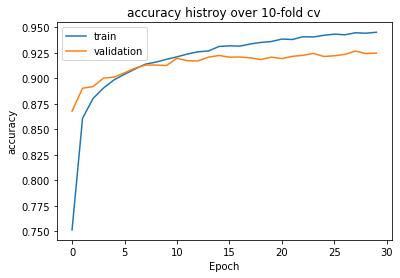

In [11]:
# plot accuracy history
plot_model_history([best_model_history['accuracy'], best_model_history['val_accuracy']],
                   legend=['train', 'validation'],
                   title='accuracy histroy over 10-fold cv',
                   ylabel='accuracy', xlabel='Epoch', figure_size=(6,4))

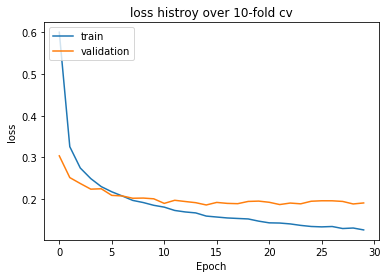

In [12]:
# plot loss history
plot_model_history([best_model_history['loss'], best_model_history['val_loss']],
                   legend=['train', 'validation'],
                   title='loss histroy over 10-fold cv',
                   ylabel='loss', xlabel='Epoch', figure_size=(6,4))

#### Saves

In [13]:
# Save all the history values for each grid_search combination to evalaute with bokeh.
save_models_history(param_list, models_history, 'bokeh dashboard/data/sfse.csv')

## Test Results

In [14]:
classes = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying'] 
y_pred = best_model.predict_classes(X_test, verbose=0)

In [15]:
print(classification_report(y_pred, y_test, target_names=classes))

              precision    recall  f1-score   support

     Walking       0.91      0.90      0.91       503
    Upstairs       0.79      0.86      0.82       435
  Downstairs       0.89      0.82      0.85       451
     Sitting       0.75      0.87      0.81       422
    Standing       0.90      0.80      0.84       598
      Laying       1.00      1.00      1.00       538

    accuracy                           0.88      2947
   macro avg       0.87      0.88      0.87      2947
weighted avg       0.88      0.88      0.88      2947



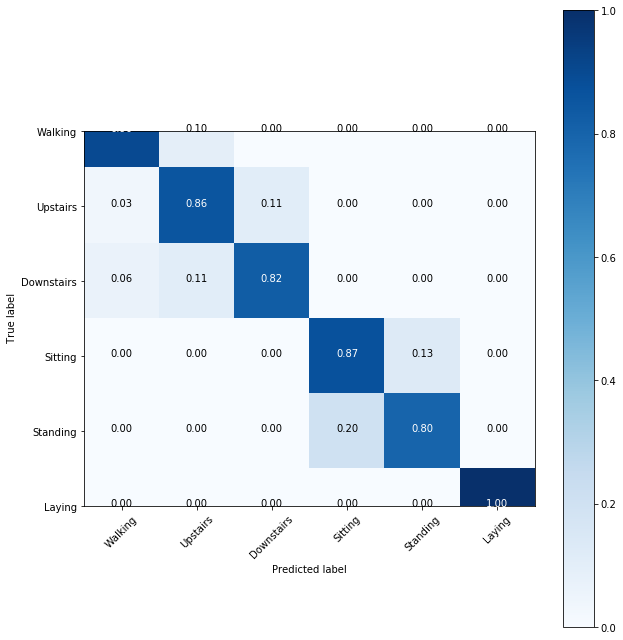

In [16]:
plot_confusion_matrix(confusion_matrix(y_pred, y_test), classes, 'Predicted label',' True label', normalize=True)

# Training with LSTM


#### Create model

In [18]:
def LSTM_model(n_timesteps, n_features, activation, dense, optimizer, n_outputs=6):
    
    '''
    model to be used in grid_search with cross fold
    input:
        n_timesteps: number of timesteps
        n_features: number of features
        n_outputs: number of outputs
        activation: activation function for nodes
        dense: number of nodes
        optimizer: optimizer function
    '''
    
    model = Sequential()

    # add LSTM layer
    model.add(LSTM(dense, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.2))
    
    # add a single dense Layer
    model.add(Dense(dense, activation=activation))
    model.add(Dropout(0.2))
   
    # add output layer
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### Resape data

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Train 

Evaluate with 10-fold cross-validaiton

In [35]:
# init params
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]


k_fold = KFold(10, True, 1)

# temporary list for storing results 
acc_his = []
loss_his = []
val_acc_his = []
val_loss_his = []


for train_ix, test_ix in k_fold.split(X_train):
    
    # select samples
    trainX, trainy = X_train[train_ix], y_train[train_ix]
    testX, testy = X_train[test_ix], y_train[test_ix]
    # evaluate model

    # add early stopping
    # es = EarlyStopping(monitor='val_accuracy', verbose=0, patience=10)

    # train model
    model = LSTM_model(n_timesteps, n_features, 'relu', 30, 'adam')
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=25, verbose=0) 
    
    # add each fold result to list
    acc_his.append(history.history['accuracy'])
    loss_his.append(history.history['loss'])
    val_acc_his.append(history.history['val_accuracy'])
    val_loss_his.append(history.history['val_loss'])
    
# caculate mean history for cross-validation
mean_acc_his  = np.mean(acc_his, axis=0)
mean_loss_his = np.mean(loss_his, axis=0)
mean_val_acc_hiss  = np.mean(val_acc_his, axis=0)
mean_val_loss_hiss = np.mean(val_loss_his, axis=0)

#### Plot results

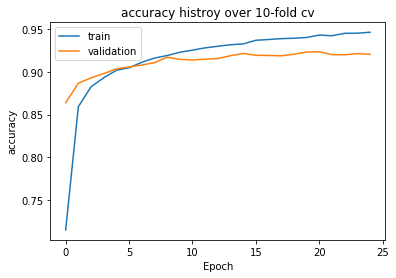

In [37]:
# plot accuracy history
plot_model_history([mean_acc_his, mean_val_acc_hiss],
                   legend=['train', 'validation'],
                   title='accuracy histroy over 10-fold cv',
                   ylabel='accuracy', xlabel='Epoch', figure_size=(6,4))

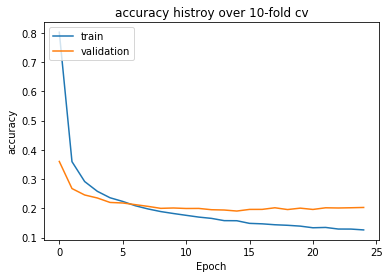

In [39]:
# plot loss history
plot_model_history([mean_loss_his, mean_val_loss_hiss],
                   legend=['train', 'validation'],
                   title='accuracy histroy over 10-fold cv',
                   ylabel='accuracy', xlabel='Epoch', figure_size=(6,4))

## Test Results

In [41]:
classes = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying'] 
y_pred = model.predict_classes(X_test, verbose=0)

In [42]:
print(classification_report(y_pred, y_test, target_names=classes))

              precision    recall  f1-score   support

     Walking       0.96      0.87      0.91       549
    Upstairs       0.79      0.84      0.81       443
  Downstairs       0.84      0.89      0.87       395
     Sitting       0.78      0.82      0.80       467
    Standing       0.84      0.81      0.83       556
      Laying       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



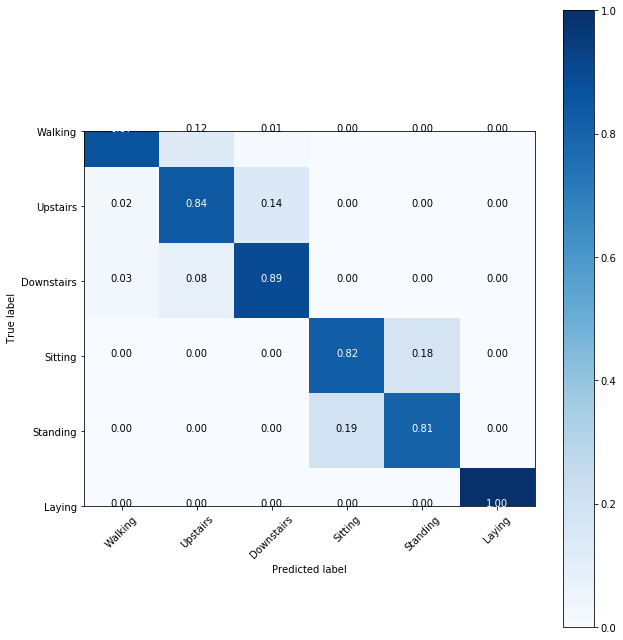

In [43]:
plot_confusion_matrix(confusion_matrix(y_pred, y_test), classes, 'Predicted label',' True label', normalize=True)

In [47]:
confusion_matrix(y_pred, y_test)

array([[475,  68,   6,   0,   0,   0],
       [ 10, 372,  61,   0,   0,   0],
       [ 11,  31, 353,   0,   0,   0],
       [  0,   0,   0, 384,  83,   0],
       [  0,   0,   0, 107, 449,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)